INFO:root:These are the duplicate rows that will be deleted:
INFO:root:       Site PF    X    Y
0         8  F  347  580
4         7  F  343  579
14        6  F  338  578
17        6  F  337  578
35        5  F  331  577
...     ... ..  ...  ...
84791     1  F  260  237
84792     2  F  260  238
84793     1  F  259  237
84794     1  F  258  237
84795     1  F  257  237

[1938 rows x 4 columns]
INFO:root:Valid holes found at top-left corners: [(268, 256), (303, 256), (338, 256), (373, 256), (198, 294), (233, 294), (268, 294), (303, 294), (338, 294), (373, 294), (408, 294), (198, 332), (233, 332), (268, 332), (303, 332), (338, 332), (373, 332), (408, 332), (443, 332), (163, 370), (198, 370), (233, 370), (268, 370), (303, 370), (338, 370), (373, 370), (408, 370), (443, 370), (163, 408), (198, 408), (233, 408), (268, 408), (303, 408), (338, 408), (373, 408), (408, 408), (443, 408), (163, 446), (198, 446), (233, 446), (268, 446), (303, 446), (338, 446), (373, 446), (408, 446), (443, 446), (1

ValueError: not enough values to unpack (expected 3, got 2)

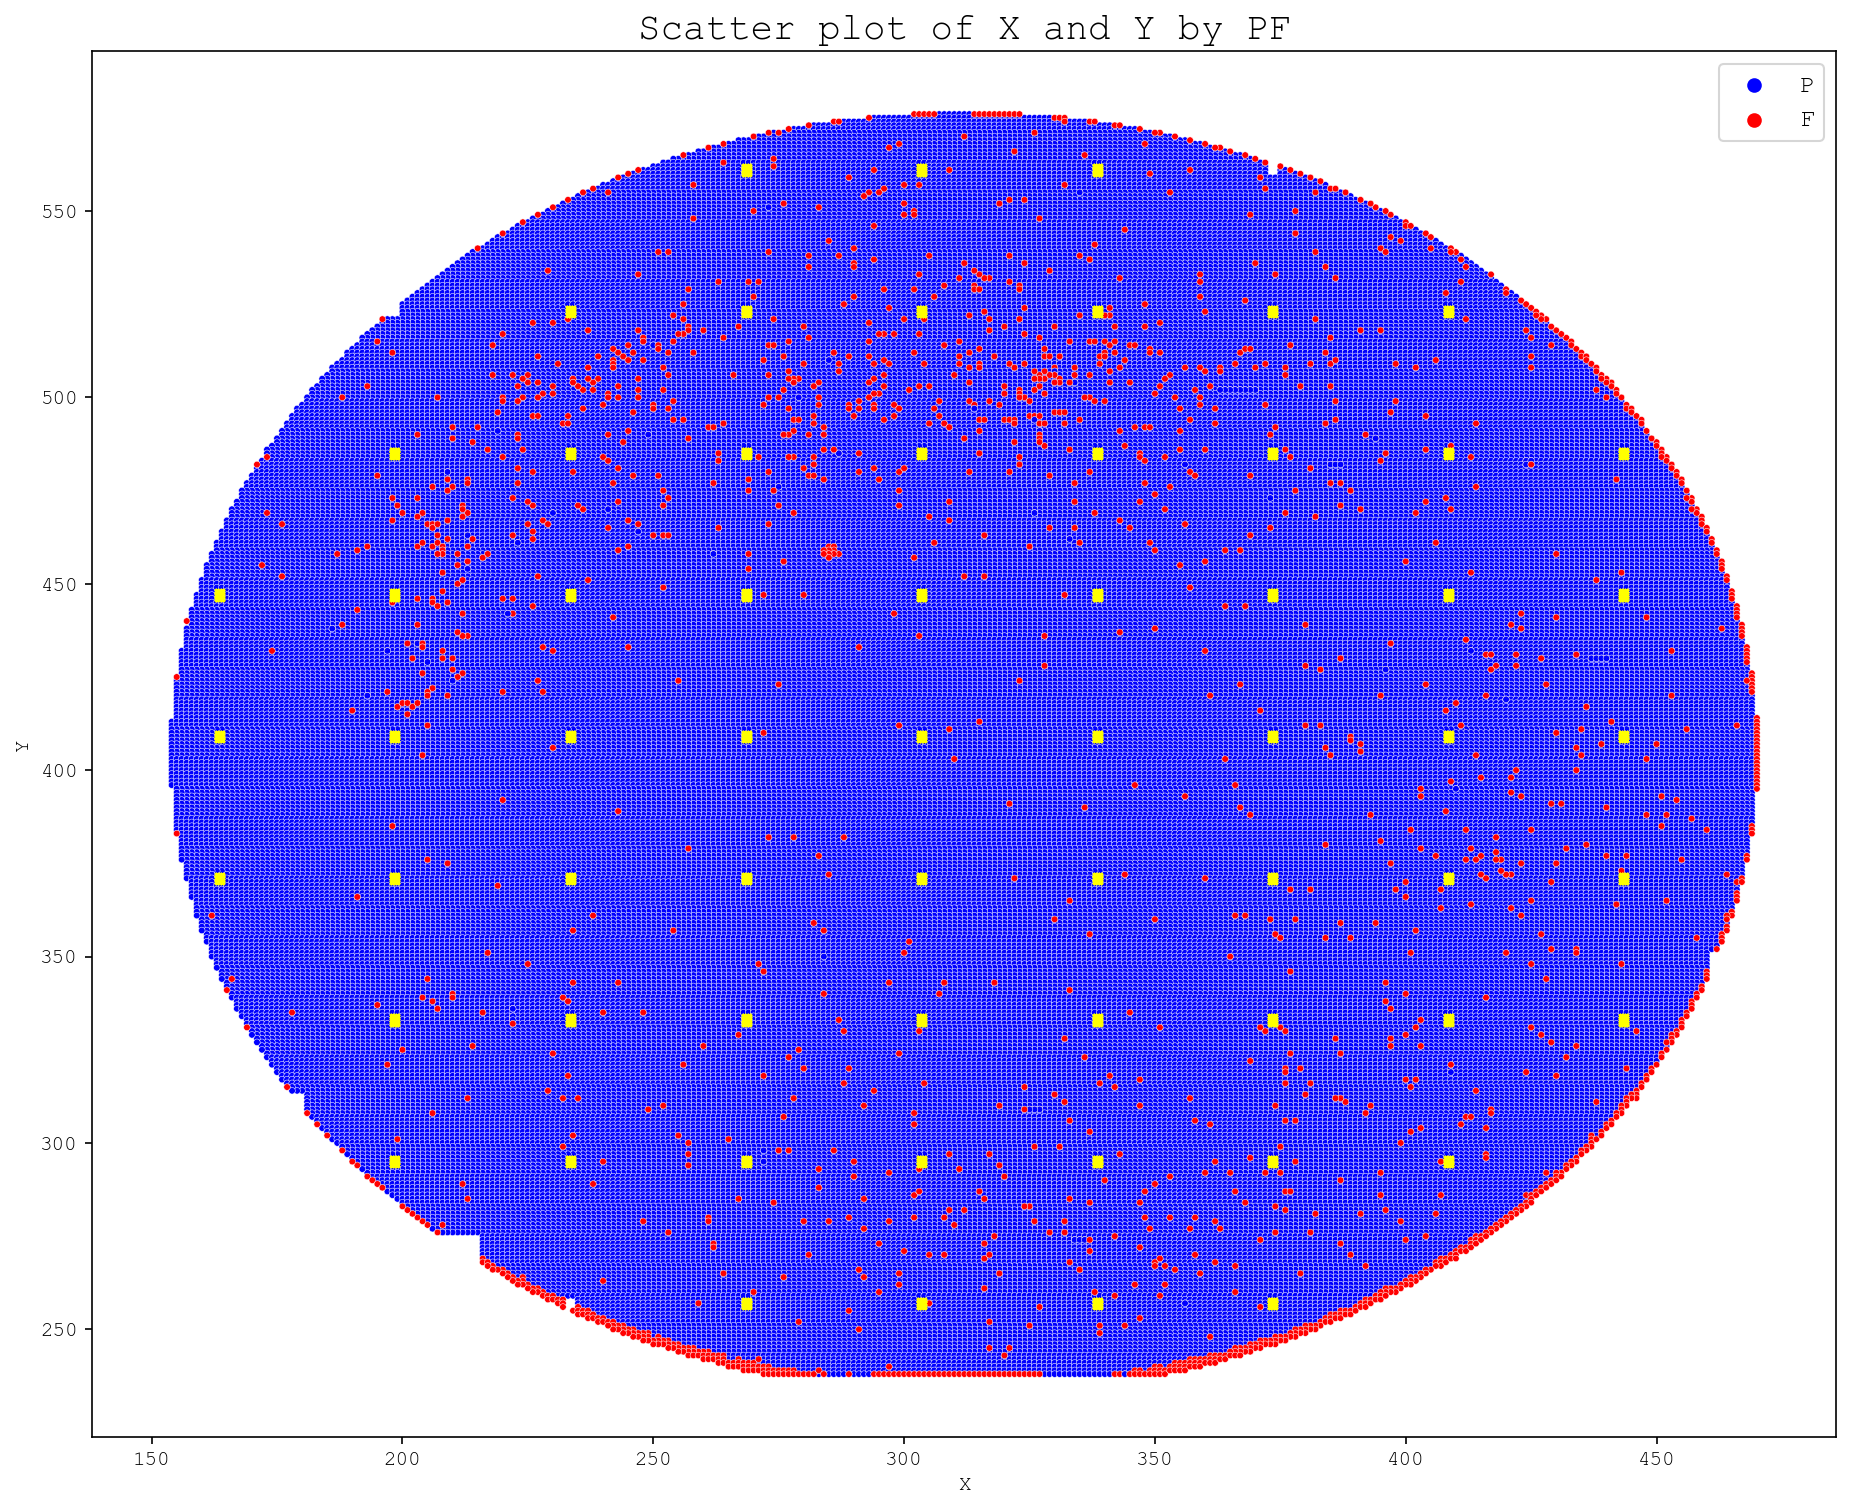

In [2]:
# 导入所需的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# 设置日志配置
logging.basicConfig(level=logging.INFO)

def load_data(filename):
    """
    加载数据文件。
    
    :param filename: 文件名路径
    :return: 数据框或None
    """
    try:
        df = pd.read_csv(filename, skiprows=range(0, 6), usecols=[1, 2, 4, 5])
        df.columns = ['Site', 'PF', 'X', 'Y']
        df.dropna(inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})
    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    """
    验证并删除数据中的重复值。

    :param df: 数据框
    :return: 处理后的数据框，要删除的数据和缺失的数据
    """
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    return df, to_delete_df, missing_df

def apply_formula(df):
    """
    对数据框应用特定公式。

    :param df: 数据框
    :return: 处理后的数据框
    """
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    """
    翻转X坐标。

    :param df: 数据框
    :return: 处理后的数据框
    """
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 258)):
    """
    调整坐标。

    :param df: 数据框
    :param offset: 偏移量，默认值(152, 258)
    :return: 处理后的数据框
    """
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    """
    在网格中查找所有的空洞。

    :param grid: 二维数组表示网格
    :return: 洞和缺失的坐标
    """
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    """
    将数据可视化。

    :param df: 数据框
    :param holes: 洞的坐标
    :param missing_coordinates: 缺失的坐标
    :param optional_value: 可选值用于过滤
    """
    plt.figure(figsize=(15, 12), dpi=150)
    plt.rcParams['font.family'] = 'Courier New'
    if optional_value:
        df = df[df['Site'] == optional_value]
    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )
    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')
    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    """
    从数据框生成TXT文件。

    :param df: 数据框
    :param txt_filename: TXT文件名
    """
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]
    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']
    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')

def find_first_hole_and_surroundings(grid):
    """
    查找第一个洞及其周围。

    :param grid: 二维数组表示网格
    :return: 第一个洞的坐标，周围的坐标和状态
    """
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    surroundings = {}
                    for dy in range(-1, 4):
                        for dx in range(-1, 3):
                            surroundings[(x+dx, y+dy)] = grid[y+dy][x+dx]
                    return (x, y), surroundings
    return None, None

def main(optional_value=None):
    all_data = []  # 初始化空列表用于存储所有数据
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    all_data.append(df)
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/最初的4列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 258)  # 你可以根据需要调整这个值
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]

    logging.info("These are the duplicate rows that will be deleted:")
    logging.info(to_delete_df)

    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']

    holes, missing_coordinates = find_all_holes(grid)
    if holes:
        logging.info(f"Valid holes found at top-left corners: {holes}.")

    for x, y in missing_coordinates:
        if df[(df['X'] == x) & (df['Y'] == y)].empty:
            new_row = {'Site': -1, 'PF': 'M', 'X': x, 'Y': y}
            df = pd.concat([df, pd.DataFrame([new_row])]).reset_index(drop=True)

    visualize_data(df, holes, missing_coordinates, optional_value)
    
    first_hole, surrounding_coordinates, surrounding_status = find_first_hole_and_surroundings(grid)
    if first_hole:
        logging.info(f"First valid hole found at top-left corner: {first_hole}.")
        logging.info(f"Surrounding coordinates: {surrounding_coordinates}")
        logging.info(f"Surrounding statuses: {surrounding_status}")
    #这里加入了total fail，pass和test的判定公式：total test=total pass的值+total fail的值   
    TOTAL_FAIL = len(to_delete_df)
    logging.info(f"TOTAL_FAIL: {TOTAL_FAIL}")

    TOTAL_PASS = len(df[df['PF'] == 'P'])
    logging.info(f"TOTAL_PASS: {TOTAL_PASS}")

    TOTAL_TEST = TOTAL_PASS + TOTAL_FAIL
    logging.info(f"TOTAL_TEST: {TOTAL_TEST}")
        
if __name__ == "__main__":
    optional_value = None
    main(optional_value)

INFO:root:Duplicate rows:        Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]
INFO:root:These are the duplicate rows that will be deleted:
INFO:root:       Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]
INFO:root:Valid holes found at top-le

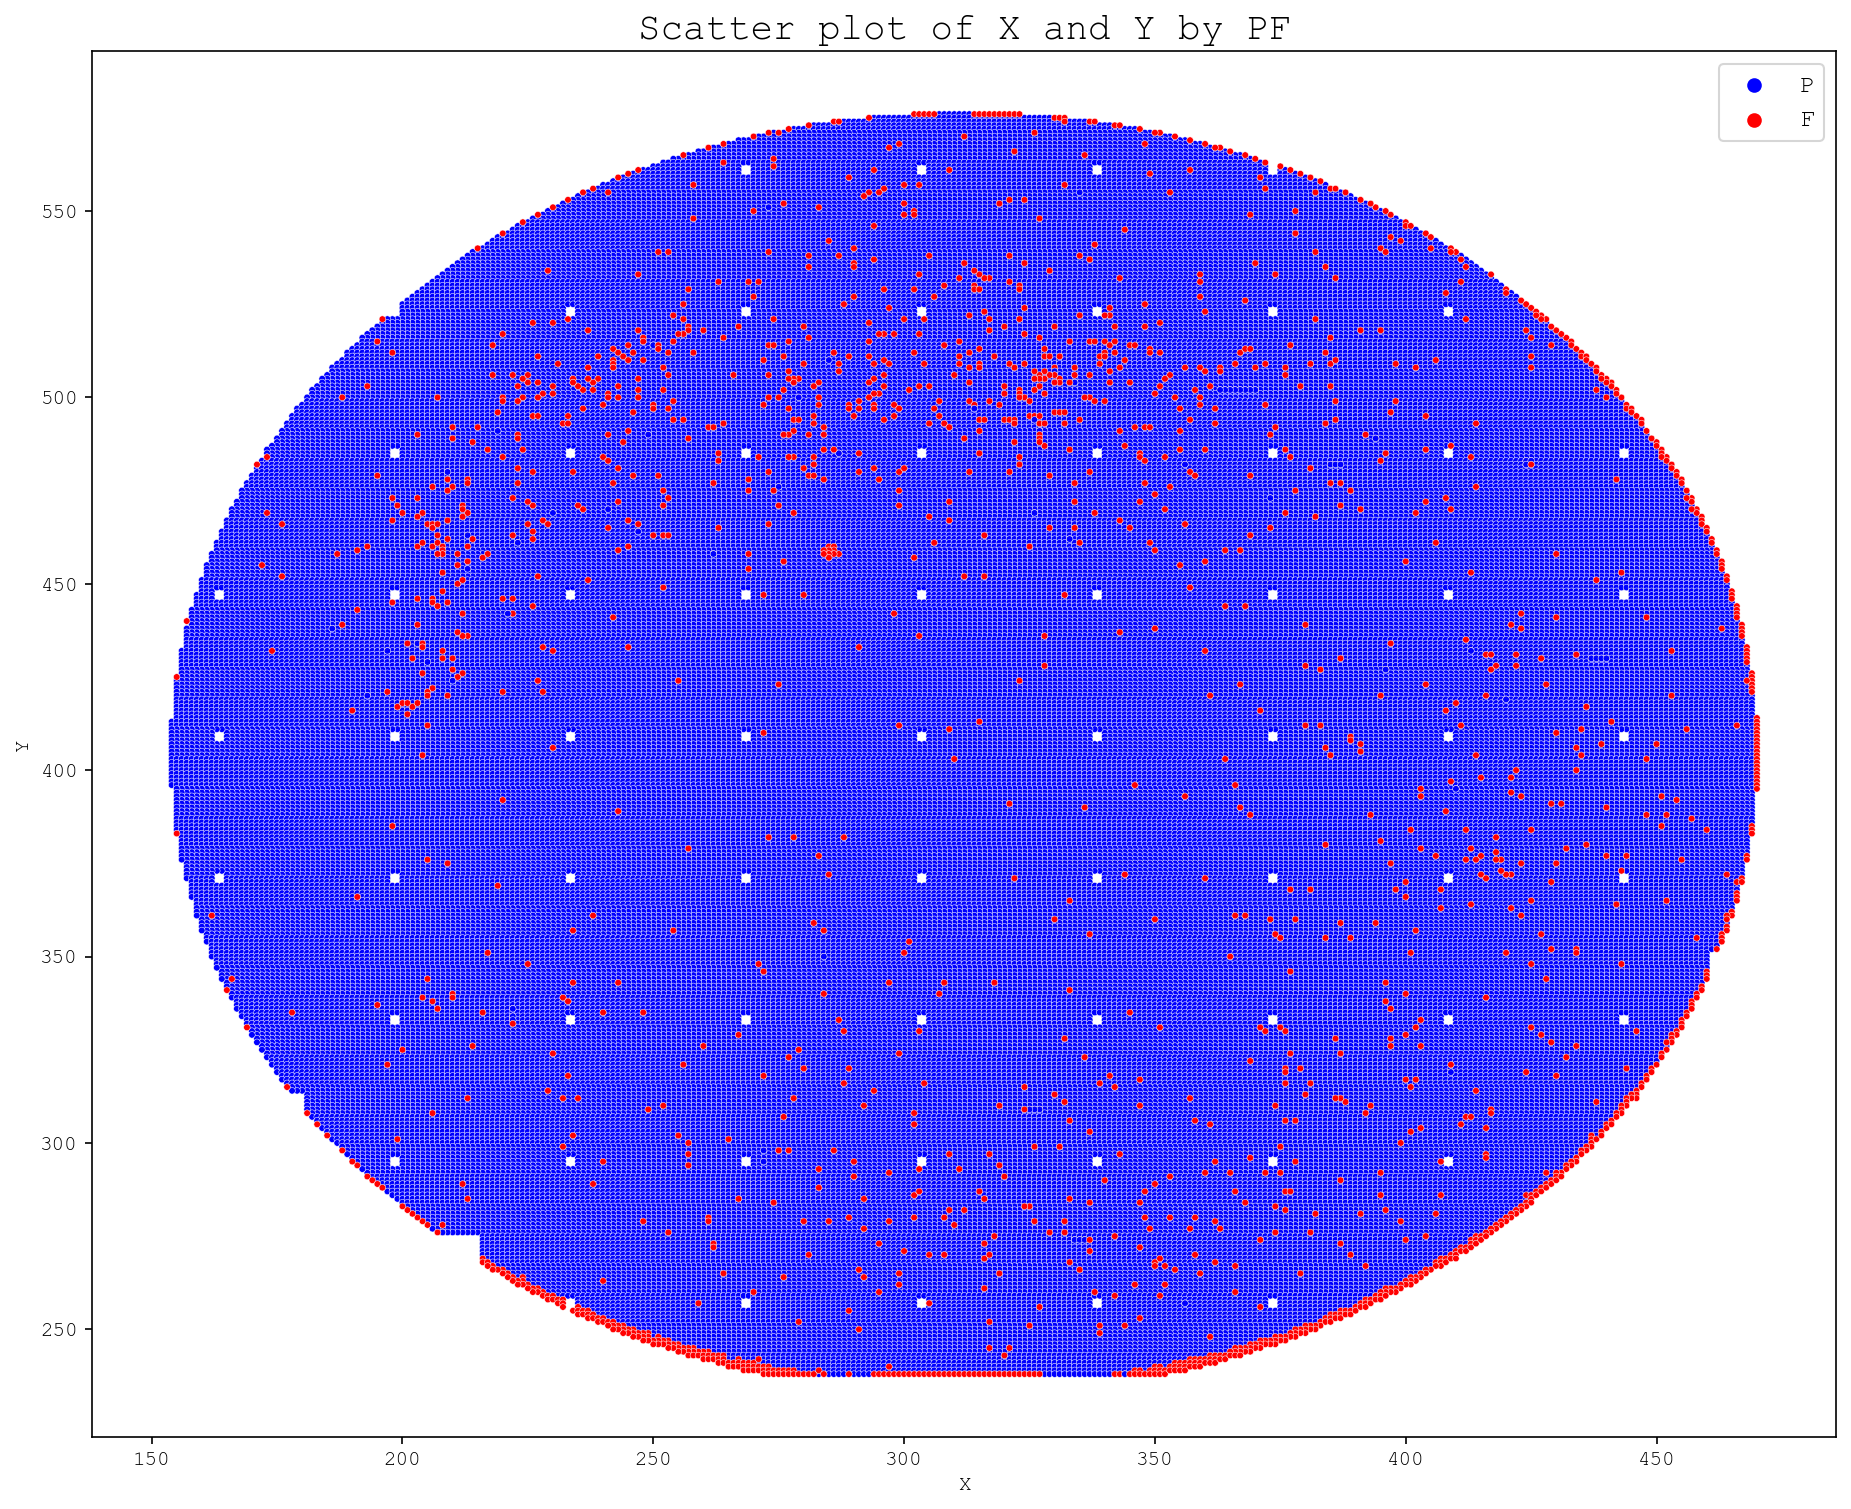

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # 读取第1, 2, 4, 5以及第10（J列）列
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # 对 J_Column 进行处理
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log the missing rows if any
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log the duplicate rows if any
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df


def apply_formula(df):
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        symbol = row['PF']
        if not pd.isna(row['J_Column']):
            symbol = row['J_Column']
        grid[int(row['Y'])][int(row['X'])] = symbol

    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')

def find_first_hole_and_surroundings(grid):
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    surrounding_coordinates = [(x+dx, y+dy) for dy in [-1, 3] for dx in range(-1, 3)] + [(x+dx, y+dy) for dy in range(-1, 4) for dx in [-1, 2]]
                    surrounding_status = [(grid[y+dy][x+dx]) for dy in [-1, 3] for dx in range(-1, 3)] + [(grid[y+dy][x+dx]) for dy in range(-1, 4) for dx in [-1, 2]]
                    return (x, y), surrounding_coordinates, surrounding_status
    return None, [], []

def main(optional_value=None):
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/加入J列变5列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 238)  
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]

    logging.info("These are the duplicate rows that will be deleted:")
    logging.info(to_delete_df)

    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']

    holes, missing_coordinates = find_all_holes(grid)
    if holes:
        logging.info(f"Valid holes found at top-left corners: {holes}.")

    for x, y in missing_coordinates:
        if df[(df['X'] == x) & (df['Y'] == y)].empty:
            new_row = {'Site': -1, 'PF': 'M', 'X': x, 'Y': y}
            df = pd.concat([df, pd.DataFrame([new_row])]).reset_index(drop=True)

    visualize_data(df, holes=[], missing_coordinates=[], optional_value=optional_value)
    
    first_hole, surrounding_coordinates, surrounding_status = find_first_hole_and_surroundings(grid)
    if first_hole:
        logging.info(f"First valid hole found at top-left corner: {first_hole}.")
        logging.info(f"Surrounding coordinates: {surrounding_coordinates}")
        logging.info(f"Surrounding statuses: {surrounding_status}")
    
    logging.info(f"X max coordinate: {df['X'].max()}")
    logging.info(f"Y max coordinate: {df['Y'].max()}")
    logging.info(f"TOTAL_TEST: {len(df)}")
    logging.info(f"TOTAL_PASS: {len(df[df['PF'] == 'P'])}")

if __name__ == "__main__":
    optional_value = None
    main(optional_value)

In [ ]:
##########C的代码############
for(y=0; y <= yMax-yMin; y++) 
{
    for(x=0; x <= xMax-xMin; x++) 
    {
        // xxxx 代表要执行的代码
    }
}

######C的代码##########
yMin2=MAXDTY; //yMin2初值，1000
yMax2=0; //yMax2初测
    for(i=0; i<TtlDice; i++){ //所有csu档记录
        if(u[i]==1){ //本行数据有效
            k1=x[i]; x无变化
            k2=y[i]-2*s[i]; //y从1-8扩散到1-15;
            psf1[k1][k2]=pf[i]; // P/F记录赋值到阵列
            if(k2>yMax2) yMax2=k2; //更新yMax2
            if(k2<yMin2)yMin2=k2;  // 更新yMin2
         }
    }
printf("Y变换后，yMin2=%d，yMax2=%d，共%d行。\r\n",yMin2,yMax2,yMax2-yMin2+1);
xMin2=xMin; //xMin不变
xMax2=xMax; //xMax不变
for(i=yMax2;i>=yMin2;i--){ // txt档左上角是(xMax2,Ynax2)，右下角是(xMin2,yMin2)
    for(j=xMax2;j>=xMin2;j--)fprintf(fpL,“c",psf1[j][i]);
    fprintf(fpL,"\r\n");
}
printf("运行结束\r\n"); // for debug only
fclose(fpL); // for debug only 

In [23]:
#成功代码，加入list1，也就是csv生成的txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

list1 = []
list2 = []

logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # 读取第1, 2, 4, 5以及第10（J列）列
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # 对 J_Column 进行处理
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log the missing rows if any
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log the duplicate rows if any
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df


def apply_formula(df):
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        symbol = row['PF']
        if not pd.isna(row['J_Column']):
            symbol = row['J_Column']
        grid[int(row['Y'])][int(row['X'])] = symbol

    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')

def find_first_hole_and_surroundings(grid):
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    surrounding_coordinates = [(x+dx, y+dy) for dy in [-1, 3] for dx in range(-1, 3)] + [(x+dx, y+dy) for dy in range(-1, 4) for dx in [-1, 2]]
                    surrounding_status = [(grid[y+dy][x+dx]) for dy in [-1, 3] for dx in range(-1, 3)] + [(grid[y+dy][x+dx]) for dy in range(-1, 4) for dx in [-1, 2]]
                    return (x, y), surrounding_coordinates, surrounding_status
    return None, [], []

def main(optional_value=None):
    global list1  # 声明 list1 是全局变量
    list1 = []  # 初始化 list1 为空列表
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/加入J列变5列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 238)  
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]


    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']

    holes, missing_coordinates = find_all_holes(grid)
    if holes:
        logging.info(f"Valid holes found at top-left corners: {holes}.")

    for x, y in missing_coordinates:
        if df[(df['X'] == x) & (df['Y'] == y)].empty:
            new_row = {'Site': -1, 'PF': 'M', 'X': x, 'Y': y}
            df = pd.concat([df, pd.DataFrame([new_row])]).reset_index(drop=True)

    # 读取 txt 文件，并将其内容储存到 list1 中
    with open(txt_filename_adjusted, 'r') as f:
        list1 = f.readlines()
    print(list1)
    

if __name__ == "__main__":
    optional_value = None
    main(optional_value) 

INFO:root:Duplicate rows:        Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]
INFO:root:Valid holes found at top-left corners: [(268, 256), (303, 256), (338, 256), (373, 256), (198, 294), (233, 294), (268, 294), (303, 294), (338, 294), (373, 294), (408, 294), (198, 332), (233, 332), (268, 332), (303, 332), (338, 332), (373, 332), (408, 332), (443, 332), (163, 370), (198, 370), (233, 370), (268, 370), (303, 370), (338, 370), (373, 370), (408, 370), (443, 370), (163, 408), (198, 408), (233, 408), (268, 408), (303, 408), (338, 408), (373, 408), (408, 408), (443, 408), (163, 446), (198, 446), (233, 446), (268, 446),

['......................................................................................................................................................FFFFFPPPPPPPFFFFFFFFFF...................................................................................................................................................\n', '.............................................................................................................................................FPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPFFF..........................................................................................................................................\n', '......................................................................................................................................FFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPFPPPPFF....................................................................................................................................\n', '.......................

In [28]:
#新加入list1，2，3
#list1为导出txt最终数据，list2是标准副本，list3是标准导出的实验数据
#这段代码是将list3里P和F变成X
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging


logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # 读取第1, 2, 4, 5以及第10（J列）列
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # 对 J_Column 进行处理
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log the missing rows if any
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log the duplicate rows if any
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df


def apply_formula(df):
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        symbol = row['PF']
        if not pd.isna(row['J_Column']):
            symbol = row['J_Column']
        grid[int(row['Y'])][int(row['X'])] = symbol

    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')

def find_first_hole_and_surroundings(grid):
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    surrounding_coordinates = [(x+dx, y+dy) for dy in [-1, 3] for dx in range(-1, 3)] + [(x+dx, y+dy) for dy in range(-1, 4) for dx in [-1, 2]]
                    surrounding_status = [(grid[y+dy][x+dx]) for dy in [-1, 3] for dx in range(-1, 3)] + [(grid[y+dy][x+dx]) for dy in range(-1, 4) for dx in [-1, 2]]
                    return (x, y), surrounding_coordinates, surrounding_status
    return None, [], []

def main(optional_value=None):
    global list1, list2, list3  # 声明 list1 和 list2 是全局变量
    list1 = []  # 初始化 list1 为空列表
    list2 = []  # 初始化 list2 为空列表
    list3 = []  # 初始化 list3 为空列表
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    standard_txt_path = 'C:/Users/TP/Downloads/CQ6248.1-01.txt'
    with open(standard_txt_path, 'r') as f:
           for line in f:
            list2.append(line.strip())
            list3.append(line.strip())# 使用strip()去掉换行符
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/加入J列变5列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 238)  
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]


    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']

    holes, missing_coordinates = find_all_holes(grid)
    if holes:
        logging.info(f"Valid holes found at top-left corners: {holes}.")

    for x, y in missing_coordinates:
        if df[(df['X'] == x) & (df['Y'] == y)].empty:
            new_row = {'Site': -1, 'PF': 'M', 'X': x, 'Y': y}
            df = pd.concat([df, pd.DataFrame([new_row])]).reset_index(drop=True)

    # 读取 txt 文件，并将其内容储存到 list1 中
    with open(txt_filename_adjusted, 'r') as f:
        list1 = f.readlines()
    

if __name__ == '__main__':
    main(optional_value=None)
    
    print("===== Content of standard_txt_copy in list3: =====")
    for line in list3:
        print(line.strip())
    
    print("===== Content of generated txt in list1: =====")
    for line in list1:
        print(line.strip())


INFO:root:Duplicate rows:        Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]
INFO:root:Valid holes found at top-left corners: [(268, 256), (303, 256), (338, 256), (373, 256), (198, 294), (233, 294), (268, 294), (303, 294), (338, 294), (373, 294), (408, 294), (198, 332), (233, 332), (268, 332), (303, 332), (338, 332), (373, 332), (408, 332), (443, 332), (163, 370), (198, 370), (233, 370), (268, 370), (303, 370), (338, 370), (373, 370), (408, 370), (443, 370), (163, 408), (198, 408), (233, 408), (268, 408), (303, 408), (338, 408), (373, 408), (408, 408), (443, 408), (163, 446), (198, 446), (233, 446), (268, 446),

===== Content of standard_txt_copy in list3: =====
.................................................................................................................................................********************************................................................................................................................................................
.........................................................................................................................................***********************************************.........................................................................................................................................
....................................................................................................................................******************FFFFFPPPPPPPFFFFFFFFFF******************...................................................................................................................

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging


logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # 读取第1, 2, 4, 5以及第10（J列）列
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # 对 J_Column 进行处理
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log the missing rows if any
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log the duplicate rows if any
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df


def apply_formula(df):
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        symbol = row['PF']
        if not pd.isna(row['J_Column']):
            symbol = row['J_Column']
        grid[int(row['Y'])][int(row['X'])] = symbol

    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')

def find_first_hole_and_surroundings(grid):
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    surrounding_coordinates = [(x+dx, y+dy) for dy in [-1, 3] for dx in range(-1, 3)] + [(x+dx, y+dy) for dy in range(-1, 4) for dx in [-1, 2]]
                    surrounding_status = [(grid[y+dy][x+dx]) for dy in [-1, 3] for dx in range(-1, 3)] + [(grid[y+dy][x+dx]) for dy in range(-1, 4) for dx in [-1, 2]]
                    return (x, y), surrounding_coordinates, surrounding_status
    return None, [], []

def main(optional_value=None):
    global list1, list2, list3  # 声明 list1 和 list2 是全局变量
    list1 = []  # 初始化 list1 为空列表
    list2 = []  # 初始化 list2 为空列表
    list3 = []  # 初始化 list3 为空列表
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    standard_txt_path = 'C:/Users/TP/Downloads/CQ6248.1-01.txt'
    with open(standard_txt_path, 'r') as f:
           for line in f:
            list2.append(line.strip())
            list3.append(line.strip())# 使用strip()去掉换行符
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/加入J列变5列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 238)  
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]


    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']


    # 读取 txt 文件，并将其内容储存到 list1 中
    with open(txt_filename_adjusted, 'r') as f:
        list1 = f.readlines()
    
if __name__ == '__main__':
    main(optional_value=None)
    
    for i in range(len(list3)):
    # 使用 Python 的字符串的 replace 方法来替换 'P' 和 'F' 为 'X'
        new_line = list3[i].replace('P', 'X').replace('F', 'X')
        list3[i] = new_line  # 更新 list3 中的该行
    
# 打印新的list3来检查
    print("===== Updated list3: =====")
    for line in list3:
        print(line.strip())

    print("===== Content of generated txt in list1: =====")
    for line in list1:
        print(line.strip())

ERROR:root:File sample.csv not found.


In [10]:
#对代码功能的介绍，导入一个不存在的sample.csv
# 导入所需的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# 配置日志信息的显示级别为 INFO
logging.basicConfig(level=logging.INFO)

# 定义一个函数，用于从CSV文件中加载数据
def load_data(filename):
    try:
        # 读取指定的列，并为其命名
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        # 删除含有缺失值的行
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        # 转换列的数据类型
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})
        
        # 对 J_Column 进行处理，满足某个条件的变为 'F'，否则变为 'P'
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')
    except FileNotFoundError:  # 文件未找到异常处理
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:  # 文件为空的异常处理
        logging.error(f"File {filename} is empty.")
        return None
    return df

# 定义一个函数，用于验证数据，并删除重复项
def validate_and_remove_duplicates(df):
    # 查找缺失X或Y的行
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # 如果有缺失的行，记录这些行
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    # 仅保留X和Y为正的行
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    # 寻找重复的行
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # 如果有重复的行，记录这些行
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    # 删除重复的行
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df

# 定义一个函数，用于对Y列的值应用一个公式
def apply_formula(df):
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

# 定义一个函数，用于翻转X坐标
def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

# 定义一个函数，用于调整X和Y坐标的值
def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

# 定义一个函数，用于寻找网格中的所有孔洞
def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            # 查找3x2的空格子
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

# 定义一个函数，用于将数据可视化
def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

# 定义一个函数，用于从DataFrame生成txt文件
def generate_txt_from_df(df, txt_filename):
    # 获取X和Y的最大值和最小值
    x_min, x_max = df['X'].min(), df['X'].max()
    y_min, y_max = df['PF'].min(), df['PF'].max()

    # 初始化一个二维数组
    grid = [['.' for _ in range(x_max - x_min + 1)] for _ in range(y_max - y_min + 1)]

    # 将DataFrame中的数据填充到二维数组
    for _, row in df.iterrows():
        x, y, pf = row['X'] - x_min, row['Y'] - y_min, row['PF']
        grid[y][x] = pf

    # 找到所有孔洞的位置
    holes, missing_coordinates = find_all_holes(grid)

    # 保存二维数组到txt文件
    with open(txt_filename, 'w') as f:
        for row in grid:
            f.write(''.join(row) + '\n')

    return holes, missing_coordinates

def main(filename='sample.csv'):
    # 从CSV文件加载数据
    df = load_data(filename)
    if df is None:
        return
    
    # 验证并删除重复数据
    df, duplicates, missing = validate_and_remove_duplicates(df)
    
    # 对数据进行处理
    df = apply_formula(df)
    df = flip_x_coordinates(df)
    df = adjust_coordinates(df)
    
    # 生成txt文件并获取孔洞的位置
    holes, missing_coordinates = generate_txt_from_df(df, 'output.txt')
    
    # 可视化数据
    visualize_data(df, holes, missing_coordinates)
    visualize_data(df, holes, missing_coordinates, optional_value=2)

if __name__ == '__main__':
    main()


ERROR:root:File sample.csv not found.


In [4]:
#简化代码
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging


logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # 读取第1, 2, 4, 5以及第10（J列）列
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # 对 J_Column 进行处理
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log the missing rows if any
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log the duplicate rows if any
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df



def apply_formula(df):
    df['Original_Y'] = df['Y']  # 保存原始的 Y 值
    df['Y'] = df['Y'] + 16 - 2 * df['Site']
    return df


def flip_x_coordinates(df):
    center_x = (df['X'].max() + df['X'].min()) // 2
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    plt.figure(figsize=(15, 12), dpi=150)

    plt.rcParams['font.family'] = 'Courier New'  # 设置全局字体
    if optional_value:
        df = df[df['Site'] == optional_value]

    sns.scatterplot(
        data=df[df['PF'].isin(['P', 'F'])],
        x='X', y='Y', hue='PF',
        palette={'P':'blue', 'F':'red'},
        s=10
    )

    for x, y in missing_coordinates:
        plt.scatter(x, y, c='yellow', s=5, marker='x')

    plt.title(
        f'Scatter plot of X and Y by PF, filtered by Site = {optional_value}' if optional_value else 'Scatter plot of X and Y by PF',
        fontname='Courier New',  # 设置单独元素字体
        fontsize=18
    )
    plt.legend(fontsize=12)
    plt.savefig(f'scatter_plot_by_PF{"_filtered" if optional_value else ""}.png')

def generate_txt_from_df(df, txt_filename):
    df = df.sort_values(by=['Y', 'X'])
    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        symbol = row['PF']
        if not pd.isna(row['J_Column']):
            symbol = row['J_Column']
        grid[int(row['Y'])][int(row['X'])] = symbol

    with open(txt_filename, 'w') as f:
        for row in reversed(grid):
            f.write(''.join(row) + '\n')


def find_original_coordinates(list2_idx, df_adjusted, offset=(152, 238)):
    row, col = list2_idx
    
    # 反向应用坐标调整
    original_x, original_y = col - offset[0], row - offset[1]
    
    # 在 df_adjusted 中查找与这些 X 和 Y 坐标相匹配的行
    matching_row = df_adjusted[
        (df_adjusted['X'] == original_x) & 
        (df_adjusted['Y'] == original_y)
    ]

    if not matching_row.empty:
        # 获取匹配行的 Site 值
        site_value = matching_row.iloc[0]['Site']
        
        # 反向应用 y 的变换公式
        original_y = original_y + 16 - 2 * site_value
    
    return matching_row, original_y

# 假设 coordinate_mapping 是已经存在的，它保存了list3中的 'P' 和 'F' 与 CSV 文件中相应坐标的对应关系
# 假设 df_adjusted 是包含 CSV 文件内容的 DataFrame，'J_Column' 是第10列的标签

def update_list3(list3, coordinate_mapping, df_adjusted, yMax):
    if yMax >= len(list3):
        print(f"Error: yMax ({yMax}) is greater than or equal to the length of list3 ({len(list3)})")
        return
    
    for i, line in enumerate(reversed(list3)):
        if yMax - i < 0:
            print(f"Index out of range: yMax - i = {yMax - i}")
            return

    # Inside update_list3 function
    for i, line in enumerate(reversed(list3)):  
        new_line = list(line)
        for j, char in enumerate(new_line):
            if char in ['P', 'F']:
                real_i = yMax - i  
                coordinate_key = f"{real_i}, {j}"
                if coordinate_key in coordinate_mapping:
                    coordinate_value = coordinate_mapping[coordinate_key]

                    matching_row = df_adjusted[
                        (df_adjusted['X'] == coordinate_value['DataFrame_X']) & 
                        (df_adjusted['Y'] == coordinate_value['DataFrame_Y'])
                    ]
                    if not matching_row.empty:
                        j_column_value = matching_row.iloc[0]['J_Column']

                        # print it here, within the same scope
                        print(f"j_column_value: {j_column_value}")

                        if j_column_value < 75.0 or j_column_value > 105.0:
                            print("Changing to 'F'")
                            new_char = 'F'
                        else:
                            print("Changing to 'P'")
                            new_char = 'P'

                        new_line[j] = new_char
                        print(f"Changed coordinate ({real_i}, {j}) to {new_char}")

                        
        list3[yMax - i] = ''.join(new_line)  # 更新 list3 的相应行

def export_list3_to_txt(list3, filename):
    with open(filename, 'w') as f:
        for line in list3:
            f.write(f"{line}\n")


def main(optional_value=None):
    coordinate_mapping = {}
    global list1, list2, list3  # 声明 list1 和 list2 是全局变量
    list1 = []  # 初始化 list1 为空列表
    list2 = []  # 初始化 list2 为空列表
    list3 = []

    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    standard_txt_path = 'C:/Users/TP/Downloads/CQ6248.1-01.txt'
    with open(standard_txt_path, 'r') as f:
           for line in f:
            list2.append(line.strip())
            list3.append(line.strip())
    for i in range(len(list3)):
        list3[i] = list3[i].replace('P', 'X').replace('F', 'X')
        
    txt_filename_adjusted = f'C:/Users/TP/Documents/加入J列变5列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None or 'X' not in df.columns:
        print("Error after load_data: DataFrame is None or missing 'X' column.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    if df is None or 'X' not in df.columns:
        print("Error after validate_and_remove_duplicates: DataFrame is None or missing 'X' column.")
        return
    df = apply_formula(df)
    df = flip_x_coordinates(df)
    xMin = df['X'].min()
    xMax = df['X'].max()
    yMin = df['Y'].min()
    yMax = df['Y'].max()
    yMax = len(list3) - 1
    # 添加偏移量调整
    offset = (152, 238)  
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]


    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']


    # 读取 txt 文件，并将其内容储存到 list1 中
    with open(txt_filename_adjusted, 'r') as f:
        list1 = f.readlines()



    # 遍历 list3
    for i, line in enumerate(reversed(list3)):  
        for j, char in enumerate(line):
            if char in ['P', 'F']:
                real_i = yMax - i  
                matching_row, original_y = find_original_coordinates((real_i, j), df_adjusted)
                if not matching_row.empty:
                    coordinate_key = f"{real_i}, {j}"
                    coordinate_value = {
                        'DataFrame_Y': matching_row.iloc[0]['Y'],
                        'DataFrame_X': matching_row.iloc[0]['X'],
                        'Original_Y': original_y
                    }
                
                # 将对应关系保存到字典里
                    coordinate_mapping[coordinate_key] = coordinate_value
                    
    update_list3(list3, coordinate_mapping, df_adjusted, yMax)
    export_list3_to_txt(list3, "C:/Users/TP/Documents/final_list3.txt")
#     if coordinate_key in coordinate_mapping:
#         print(f"Found coordinate_key: {coordinate_key}")  # Debug print
#     # ...
#     else:
#         print(f"coordinate_key not found: {coordinate_key}")  # Debug print
#     print(f"j_column_value: {j_column_value}")
#     if j_column_value < 75.0 or j_column_value > 105.0:
#         print("Changing to 'F'")
#         new_char = 'F'
#     else:
#         print("Changing to 'P'")
#         new_char = 'P'
#     new_line[j] = new_char  # 更新字符
#     print(f"Changed coordinate ({real_i}, {j}) to {new_char}")



    
if __name__ == '__main__':
    main(optional_value=None)


INFO:root:Duplicate rows:        Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]


In [ ]:
# list1 存储生成的文本文件（由 df_adjusted 衍生而来）的每一行。
# list2 存储标准文本文件的每一行。
# list3 是 list2 的副本，并且后面被修改，所有的 'P' 和 'F' 被替换为 'X'。
# 将list2里的文本储存在list3中，将list3里的P和F变成X,由于刚刚已经知道了P和F对应CSV文件数据里的坐标，
# 依照再依据新的判断标准将X改成P或者F。新的判断标准如下：通过阅读CSV文件中的第十行，
# 如果该数据栏无数据就是F，如果数据<75.0就是F，如果数据大于105.0也是F，其余条件则为P。

In [ ]:
for(i=0;i<TtlRec;i++){ #所有csv档记录
    if(v[i]==1){ #本行数据有效
        k1=y[i]+16-2*s[i];
        k1=yMax2-k1;  #最小值8，最大值yMax2-yMin2
        k2=xMax2-x[i]; #最小值0，最大值xMax2-xMin2
        indx[k1][k2]=i;
        data[k1][k2]=d[i];
        tmp=b[i];
        bt[tmp]++;
        bin[k1][k2]=b[i];
        psf1[k1][k2]=pf[i];
        if((d[i]>75.0)&&(d[i]<105.0))psf1[k1][k2]='P';
        else psf1[k1][k2]='F';
    }
}


In [ ]:
f2f=0;
f2m=0
f2p-0;
p2p=0;
p2m=0;
p2f=0;
Changed=5;
for(i=0;i<=yMax2-yMin2;i++){
    for(j=0;j<=xMax2-xMin2;j++){
        k1=i+y0ffset;
        k2=j+x0ffset;
        if(psf1[i][j]=='.') continue;
        else if((data[i][j]>75.6)&&(data[i][j]<105.0)){
            CpyTxt[k1][k2]='1';
            p2p++;
        }
        else if((data[i][j]>76.6)&&(data[i][j]<=75.0)){
            CpyTxt[k1][k2]='M';
            f2m++;
            Changed++;
            bt['M']++;
            k3-indx[i][j];
            tmp=b[k3];
            bt[tmp]--;
        }
        else {
            CpyTxt[k1][k2]-'F';
            f2f++;
        }
    }
}
printf("\r\n改变标准后，计算计数，共有:\r\n");
printf("%d个pass不变，%d个Fail不变。\r\n",p2p,f2f);
printf("%d个fail变2档，%d个Fail变1档。\r\n"，f2m,f2p);
printf("%d个pass变2档，&d个pass变fail。\r\n",p2m,p2f);
printf("共计变更%d处，失效品总计&d。 \r\n",Changed,f2f+p2f);
printf("1档品总计%d，2档品总计&d，1+2档合计%dDice。\r\n",p2p+

In [ ]:
# 初始化
TtlRec = len(csv_data)
indx = {}  # 存储映射关系的字典
data_matrix = {}  # 用于存储data的二维数组
bt = {}  # 用于存储bt的字典
bin_matrix = {}  # 用于存储bin的二维数组
psf1_matrix = {}  # 用于存储psf1的二维数组
ppsf1_matrix = {}  # 用于存储ppsf1的二维数组

# 假设xMax2, yMax2是已知的
xMax2 = 0  # 请设置为实际值
yMax2 = 0  # 请设置为实际值

# 转换
for i in range(TtlRec):
    if int(csv_data[i][0]) == 1:  # 假设v[i]存储在CSV的第一列
        s = int(csv_data[i][1])  # 假设s存储在CSV的第2列
        pf = str (csv_data[i][2])  # 假设pf存储在CSV的第3列
        x = int(csv_data[i][4])  # 假设x存储在CSV的第5列
        y = int(csv_data[i][5])  # 假设y存储在CSV的第6列
        d = float(csv_data[i][3])  # 假设d存储在CSV的第四列
#         b = int(csv_data[i][5])   # 假设b存储在CSV的第六列
        j = float (csv_data[i][9])   # 假设b存储在CSV的第10列
        
        k1 = y + 16 - 2 * s
        k1 = yMax2 - k1  
        k2 = xMax2 - x 

        indx[(k1, k2)] = i
        data_matrix[(k1, k2)] = d
        bt[d] = bt.get(d, 0) + 1  # 使用字典的get方法，如果b不存在则返回0
        bin_matrix[(k1, k2)] = b
        psf1_matrix[(k1, k2)] = pf

        if 75.0 < j < 165.0:
            psf1_matrix[(k1, k2)] = 'P'
        else:
            psf1_matrix[(k1, k2)] = 'F'


In [ ]:
#现在，记住我的简历，在之后我提供的每一个问题都会包含一个不同的公司的介绍以及他们对招聘人员的要求。你要给我一份极具专业的cover letter，并且包含我的情况介绍。我的情况是刚毕业的大学生，我在澳洲的悉尼度过了研究生生涯，在墨尔本度过了我的本科生涯。我很热爱澳大利亚。我有4年的485 Temporary graduate 签证，我很期待第一份工作。我的性格是热情开朗，热爱学习新的知识。注重自我管理和problem solving。下面是我的简历，你回答的每个cover letter都要基于我的简历和我上面介绍的情况来写：Adrian Hou
Adrian Hou
U904/ 1 Chippendale Way, Chippendale, NSW, Australia, 2008
Tel: 61-414-010-995 Email: adrianyhou@outlook.com
Linkedin: https://www.linkedin.com/in/adrian-hou-81097527b/
Career Profile
• Master’s graduate in Information Technology from the University of Sydney, specializing in data 
management and analytics. Completed the degree in September 2023
• Earned a Bachelor of Computer Science with Distinction from Deakin University in 2021.
• Seasoned programmer with over 3 years of hands-on experience in languages such as C#, JavaScript, 
and Python. Proficient in web and mobile application development, distributed and parallel systems, 
natural language processing, networking, and security software development. Proficient in a variety of 
Office software products, such as Excel, PowerPoint, etc.
• Holder of a Temporary Graduate visa (485). Open to exploring various career paths, not limited to 
programming. An extroverted and dynamic individual who thrives in customer and team interactions. 
Passionate about learning new technologies and driven to contribute positively to team environments.
Education
02/2022 – 09/2023 Master of Information Technology
University of Sydney, Sydney, Australia
• Specialisation: Data Management and Analytics
• Graduated with average mark: 72%
02/2020 – 11/2021 Bachelor of Computer Science
Deakin University, Melbourne, Australia
• Data Mining and Machine Learning (HD), Data Capture Technologies (HD), 
IT Placement (HD), Advanced Algorithms (HD)
• Graduated with Distinction
02/2018 – 10/2019 Diploma of Information Technology
Monash College, Melbourne, Australia
Intern Experience
8/2021 – Present Nanjing Top Power ASIC Co., Ltd.
Nanjing, China
Role: Virtual program developer 
• The company specializes in the design and development of applicationspecific integrated circuits (ASICs).
• What I did: Integrated circuit data visualization, virtual chip program 
development, technology consulting and support for customers.
11/2020 – 02/2021 UTU TECHNOLOGY PTY LTD
Melbourne, VIC
Role: Computer Science Intern
• 160 hours (3 months) of internship are recorded. Join Hackathon activity.
• What I did: As a Tech Intern participated in front-end development projects 
and app user tests, Event planning and social media management.
Project Experience
03/2023 – 06/2023 Group-based Capstone- Development of Mobile Application on pesticide safety
Role of the project manager, system designer, program developer. 
• This project aims to develop a mobile application that 
incorporates evidence-based research collected in Northwest 
Cambodia to promote safe working practices when applying 
chemical pesticides. 
• My task: Designed and implemented a clean architecture for an 
unfinished component in a developing large software system, from 
code-level troubleshooting of traffic anomalies to maintenance of 
our most cutting-edge services. Optimized API performance and 
scalability by employing state-of-the-art Express.js techniques and 
best practices, yielding a 45% improvement in response times and 
supporting higher user traffic. Vue.js framework and HBuilder are 
utilized to implement the mobile application based on the system 
design.
• Achievements: Enhancing farmer safety and Improving productivity and food 
security. As a project manager, I foster an environment where everyone feels 
valued, heard, and empowered to contribute their unique perspectives.
Additionally, as a program developer, I ensure that the applications I design and 
develop prioritize accessibility and inclusivity. I advocate for user-centric 
design practices that consider diverse user needs and preferences
06/2021 – 11/2021 System Design And Prototyping
Code most programs; Market research; Project demonstration
• The main goal of the design is to help local business owners manage 
the number of customers in their stores during a global pandemic.
• Our prototype has facial recognition, mobile notifications, daily 
status, and time displays. Verified faces can be stored in a face
database.
• Use Python and related libraries such as cv2 and face_recognition. 
Enhanced application interactivity by applying Python and JavaScript 
fundamentals, leading to a 20% improvement in data handling efficiency 
for web applications, while demonstrating versatility in addressing new 
problems.
• Techniques used: face recognition techniques, computer vision, and 
classifiers. Third-party tool: If This Then That (IFTTT)
06/2021 – 11/2021 Capstone Team Project- Data Mining and Machine Learning Group Task
Senior Backend developer, Deakin University
• This project's main objective is to create an IOS application that
matches individuals who represent organizations where a forged 
partnership can result in research and development.
• What I did: Assist to refine and improve the matching algorithm. Frontend and back-end integration using the Google Cloud platform. 
Improve UI/UX design concepts with front-end staff. Developed 
comprehensive unit tests for the newly refactored system, ensuring 
robust functionality and minimizing the risk of potential bugs, 
ultimately improving code reliability by 25%
• I organized every group meeting with junior students and mentored 
them to use the waterfall methodology to develop the following 
Android app. After I graduated, they gave me feedback that they were 
still using the method I taught them at the time to overcome problems.
• Achievement: Five-star contribution marked by the team leader. Full 
contribution marked during all processes.
02/2020 – 06/2020 Capstone Team Project- SDN IoT Protection
Junior student, Squad2, Deakin University
• The main task of SDN IoT squad 2 is to develop a 5G DoS and DDoS 
mitigation strategy, using a standard development environment for the 
company’s technical department.
• My task: Testing the 5G network load capacity and response 
means when encountering network attacks such as a DDoS
attack. Add new functionality to the system, fostering good 
development habits and covering potential edge cases, resulting 
in a 30% increase in overall code quality.
• Achievements: HD of group presentation and HD of individual presentation
 
Part time Job Experience
08/2022 – 12/2022 Part time job No.9 Karaoke Bar 
Service Staff
• Collaborated effectively with a diverse team to deliver seamless and efficient 
service in a fast-paced environment.
• Demonstrated strong communication skills by effectively addressing customer 
inquiries, resolving conflicts, and providing timely assistance.
•
12/2022 – 07/2022 Part time job Chi body care
Medicine consultation, remedial treatment
• As an IT student, I am aware of the harmful effects of prolonged sitting and 
improper posture on the spine, so I studied relaxation massage and deep 
recovery Massage here. This job relievesthe financial stress of my student life.
• This work experience helped me to improve my own posture and give me a 
healthy body to face future challenges, and also taught me to listen patiently to 
the needs of customers, I applied the experience I learned to collect needs and 
feedback from clients on capstone projects.
#你要给我一份极具专业的cover letter，并且包含我的情况介绍。我的情况是今年9月份毕业的大学生，我在悉尼大学度过了IT研究生生涯，而且我的Specialisation是Data Management and Analytics。在迪肯大学完成了Computer Science的本科学位。我很热爱澳大利亚。我有4年的485 Temporary graduate 签证，我很期待第一份工作。#在墨尔本生活过4年，在悉尼和阿德莱德都生活过一年以上，具有很强的融入当地生活的能力和适应环境的能力
#强调我的485 Temporary graduate签证可以为我提供5年以上在澳大利亚境内有权利合法并且全职工作。我的计划是一直在澳洲的IT行业工作，因为该公司的职业理念和发展空间都与我相匹配，所以我想一直在公司工作。当我工作了两年之后，我将申请成为澳洲的永久居民，这会使我接着为澳大利亚的IT行业以及贵公司创造价值。我将利用我所学的知识为这个公司做出贡献，也会接着学习新的知识为我的团队提供更专业的IT帮助。强调我学习和问题解决能力很强，具有自我管理和时间管理的能力。
#因为我的Diploma，本科和master都是计算机学位，这使得我拥有丰富的计算机知识储备。而我的两段实习经历（一段墨尔本的一段中国的），使得我深入的了解了不同文化背景下工作的不同，也增强了我的计算机实践经验，同时让我更好的了解了真实的职场，锻炼了我团队协作能力和个人问题解决能力。加上我的研究生阶段，Specialisation是Data Management and Analytics，所以我认为我有能力在选择IT的同时还能选择Analytics，因为我可以用我强大的计算机知识和分析工具去更快更精准的完成分析任务。我觉得我的master学位时学到的知识可以更好的帮助我未来的团队解决更加困难的任务，也是我有自信申请这个职位的原因。

In [2]:
import pandas as pd
import logging


def read_text_to_matrix(filename):
    matrix = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            row = []
            for char in line.strip():
                row.append(char)
            matrix.append(row)
    return matrix

def find_coordinates(matrix, symbols):
    coordinates = {}
    for symbol in symbols:
        coordinates[symbol] = []
        
    for i, row in enumerate(matrix):
        for j, char in enumerate(row):
            if char in symbols:
                coordinates[char].append((i, j))
                
    return coordinates

def print_matrix(matrix):
    for row in matrix:
        print("".join(row))

def main():
    filename = "C:/Users/TP/Documents/testcase-01.txt"  
    matrix = read_text_to_matrix(filename)
    print_matrix(matrix)

    symbols_to_find = ['1', '4', '*', 'F']
    coordinates = find_coordinates(matrix, symbols_to_find)

    for symbol, coords in coordinates.items():
        print(f"The coordinates of '{symbol}' are: {coords}")

if __name__ == "__main__":
    main()


Product name = AAAAA
Wafer size   = 5 inch
Lot     name = ABCDEFG.1
Wafer-ID     = ABCDEFG.1-01
X max coor.  = 121
Y max coor.  = 122
Flat         = 0 (UP)

MARK Symbol  = "#"

TOTAL_TEST: 10708
TOTAL_PASS: 10433 Pass Die="1","4"
TOTAL_FAIL: 275 Fail Die="F"
.........................................................................................................................
.......................................*********************************************.....................................
....................................**************************************************...................................
..................................*******FFFFFFFF111FFFFFFFFFFFFFFFFF1111111111FFF******.................................
.................................*******1111111111111111111111111111F11111111111111F******...............................
...............................*******111111111111111111111111111111111111111111111411******.............................
.........

In [33]:
import pandas as pd
import logging

def read_and_preprocess_csv(file_path):
    # 读取CSV文件，不跳过任何行
    df = pd.read_csv(file_path, header=None, dtype=str)  # 全部当作字符串读取
    
    # 提取前7行的非数据内容
    metadata = df.iloc[:7, :]
    
    # 提取并重命名第8行之后的相关列
    selected_df = df.iloc[7:, [1, 2, 4, 5, 8]]
    selected_df.columns = ["Site", "PF", "X", "Y", "I"]
    
    # 数据类型转换
    selected_df["Site"] = pd.to_numeric(selected_df["Site"], errors='coerce')
    selected_df["X"] = pd.to_numeric(selected_df["X"], errors='coerce')
    selected_df["Y"] = pd.to_numeric(selected_df["Y"], errors='coerce')
    selected_df["I"] = pd.to_numeric(selected_df["I"], errors='coerce')
    
    # 数据预处理
    cleaned_df, to_delete_df, missing_df = validate_and_remove_duplicates(selected_df)

    return metadata, cleaned_df, to_delete_df, missing_df

def validate_and_remove_duplicates(df):
    # 显式地转换数据类型
    df["Site"] = pd.to_numeric(df["Site"], errors='coerce')
    df["X"] = pd.to_numeric(df["X"], errors='coerce')
    df["Y"] = pd.to_numeric(df["Y"], errors='coerce')
    df["I"] = pd.to_numeric(df["I"], errors='coerce')

    # 检查缺失值
    missing_df = df[df.isna().any(axis=1)]

    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")

    # 删除"I"列中的空值（missing value）
    df = df.dropna(subset=["I"])

    # 确保"Site"列在1-8之间
    df = df[df["Site"].between(1, 8)]

    # 确保"PF"列只包含"P"或"F"
    df = df[df["PF"].isin(["P", "F"])]

    # 过滤"X"和"Y"列中的负值和非整数值
    df = df[(df["X"] >= 0) & (df["Y"] >= 0)]

    # 删除重复行，只保留最后出现的一行
    to_delete_mask = df.duplicated(subset=["Site", "PF", "X", "Y", "I"], keep='last')
    to_delete_df = df[to_delete_mask]

    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")

    df = df.drop_duplicates(subset=["Site", "PF", "X", "Y", "I"], keep='last')

    return df, to_delete_df, missing_df

# 用法示例
if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    metadata, cleaned_df, to_delete_df, missing_df = read_and_preprocess_csv("C:/Users/TP/Documents/ABCDEFG.1-01.csv")


INFO:root:Missing rows:        Site PF    X    Y   I
7         8  F  291  358 NaN
8         7  F  290  359 NaN
10        7  F  289  359 NaN
12        6  F  288  360 NaN
15        6  F  287  360 NaN
...     ... ..  ...  ...  ..
10987     3  F  268  251 NaN
10988     7  F  266  247 NaN
10989     7  F  265  247 NaN
10990     2  F  240  252 NaN
10991     1  F  238  253 NaN

[552 rows x 5 columns]


Metadata:
        0      1    2          3           4           5       6     7   \
0                         Test_No         0.1         0.2     1.1   2.1   
1                            Note  Coordinate  Coordinate     NaN   NaN   
2                        Seq_Name           X           Y      OS  ISTD   
3                       Parm_Name           X           Y  OS_VIN  Istd   
4                             Max                            -0.2   -35   
5                             Min                              -1  -120   
6  Device#  Site#  P/F        Bin                             NaN   NaN   

      8       9       10      11       12  
0    3.1     4.1     4.2     4.3      4.4  
1    NaN     NaN     NaN     NaN      NaN  
2  VBAT0  VCHECK  VCHECK  VCHECK   VCHECK  
3  Vbat0       N     VAV   CHECK  CHECK_N  
4  4.473       0       0       5      3.5  
5   3.92       0       0      -5     -0.5  
6    NaN     NaN     NaN     NaN      NaN  
Cleaned DataFrame:
       Site PF    

In [2]:
pip install matplotlib pytesseract pillow


Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

def read_and_preprocess_csv(file_path):
    """
    读取并预处理CSV文件。
    """
    # 从CSV文件中读取数据，忽略前7行（可能是无关紧要的说明或标题）
    df = pd.read_csv(file_path, skiprows=range(0, 7))

    # 选择与问题相关的列，并对其重新命名
    df = df.iloc[:, [1, 2, 3, 4, 5, 8]]  # 选择第二到第九列的数据
    df.columns = ["Site", "PF", "Bin", "X", "Y", "I"]  # 对所选列进行重新命名

    # 对数据进行预处理，主要是数据验证和删除重复项
    cleaned_df, to_delete_df, missing_df = validate_and_remove_duplicates(df)

    return cleaned_df, to_delete_df, missing_df

def validate_and_remove_duplicates(df):
    """
    验证数据并移除重复的行。
    """
    # 找出X, Y, I列中缺失值的行
    missing_df = df[(df['X'].isna()) | (df['Y'].isna()) | (df['I'].isna())]

    # 如果存在缺失值的行，则记录下来
    if not missing_df.empty:
        logging.info(f"存在缺失值的行: {missing_df}")

    # 根据特定条件过滤数据，确保数据中的X和Y都是正数，Bin列的值只包括1和4
    df = df[(df['X'] >= 0) & (df['Y'] >= 0) & (df['Bin'].isin([1, 4]))]

    # 查找重复的行
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'Bin', 'X', 'Y', 'I'], keep='last')
    to_delete_df = df[to_delete_mask]

    # 如果存在重复的行，记录下来
    if not to_delete_df.empty:
        logging.info(f"重复的行: {to_delete_df}")

    # 删除重复的行
    df = df.drop_duplicates(subset=['Site', 'PF', 'Bin', 'X', 'Y', 'I'], keep='last')

    return df, to_delete_df, missing_df

def store_data_to_flipped_array_and_list(cleaned_df):
    """
    将清洗后的数据存储到一个翻转的数组和一个列表中。
    """
    # 获取X和Y的范围
    xMin, xMax = cleaned_df['X'].min(), cleaned_df['X'].max()
    yMin, yMax = cleaned_df['Y'].min(), cleaned_df['Y'].max()

    # 根据X和Y的范围创建一个空的对象数组
    data_array = np.empty((yMax - yMin + 1, xMax - xMin + 1), dtype=object)
    data_array.fill(None)

    # 创建一个字典来存储 (x, y) 到 Bin 的映射
    bin_dict = {}

    # 遍历清洗后的数据，将其填充到数组和字典中
    for index, row in cleaned_df.iterrows():
        x, y = row['X'], row['Y']
        bin_value = row['Bin']
        data_array[yMax - y, xMax - x] = (x, y)
        bin_dict[(x, y)] = bin_value  # 保存Bin值

    return data_array, bin_dict

def visualize_to_txt(data_array, bin_dict, output_path):
    """
    将数据可视化为文本并保存到文件。
    """
    # 打开指定的输出文件并开始写入
    with open(output_path, 'w') as f:
        # 遍历二维数组
        for row in data_array:
            for cell in row:
                # 如果该单元格为空，则写入'.'
                if cell is None:
                    f.write('.')
                else:
                    x, y = cell
                    # 从字典中获取Bin值，如果找不到，则使用默认值'F'
                    bin_value = bin_dict.get((x, y), 'F')

                    if bin_value == 1:
                        f.write('1')
                    elif bin_value == 4:
                        f.write('M')
                    else:
                        f.write('F')
            # 每一行结束后，写入一个换行符
            f.write('\n')

if __name__ == "__main__":
    # 设置日志记录的配置
    logging.basicConfig(level=logging.INFO)

    # 读取和预处理CSV文件
    cleaned_df, to_delete_df, missing_df = read_and_preprocess_csv("C:/Users/TP/Documents/CQ6248.1-01.csv")
    
    # 将清洗后的数据存储到一个翻转的数组和一个字典中
    data_array, bin_dict = store_data_to_flipped_array_and_list(cleaned_df)

    # 将数据可视化为文本并保存到文件
    visualize_to_txt(data_array, bin_dict, "C:/Users/TP/Documents/output1.txt")





    

INFO:root:存在缺失值的行:        Site PF  Bin    X    Y   I
3         7  F    3  343  579 NaN
13        6  F    3  338  578 NaN
16        6  F    3  337  578 NaN
34        5  F    3  331  577 NaN
70        4  F    3  322  576 NaN
...     ... ..  ...  ...  ...  ..
86797     1  F    3  262  237 NaN
86799     3  F    3  262  239 NaN
86803     2  F    3  260  238 NaN
86804     1  F    3  259  237 NaN
86806     1  F    3  257  237 NaN

[858 rows x 6 columns]
INFO:root:重复的行:        Site PF  Bin    X    Y       I
75307     4  F    4  428  288  4.3879
80471     1  F    4  210  269  4.3385
83224     6  F    4  253  250 -0.1895
84716     6  F    4  277  242 -0.1891


In [8]:
##一个简易的UI模型
#将CSV转化成TXT
# 导入tkinter库，用于创建图形用户界面
import tkinter as tk
# 导入filedialog和messagebox模块，用于打开文件对话框和显示消息框
from tkinter import filedialog, messagebox
# 导入csv库，用于处理CSV文件
import csv
# 导入difflib库，用于比较文件的不同
import difflib

# 定义一个函数，用于将CSV文件转换成TXT文件
def convert_csv_to_txt(file_path):
    # 以读模式打开CSV文件
    with open(file_path, 'r') as csv_file:
        # 创建一个CSV文件阅读器
        reader = csv.reader(csv_file)
        # 替换文件路径中的.csv为.txt，得到TXT文件的路径
        txt_file_path = file_path.replace('.csv', '.txt')
        
        # 以写模式打开TXT文件
        with open(txt_file_path, 'w') as txt_file:
            # 遍历CSV文件的每一行
            for row in reader:
                # 将CSV文件的每一行写入到TXT文件，并使用'\t'（制表符）分隔每个元素
                txt_file.write('\t'.join(row) + '\n')
                
    # 返回TXT文件的路径
    return txt_file_path

# 定义一个函数，用于比较两个TXT文件的不同
def compare_txt_files(file1, file2):
    # 以读模式打开两个TXT文件
    with open(file1, 'r') as f1, open(file2, 'r') as f2:
        # 使用difflib库的ndiff方法比较两个文件的不同，并将结果存入diff变量
        diff = difflib.ndiff(f1.readlines(), f2.readlines())
        
    # 返回比较结果，每个不同占一行
    return '\n'.join(diff)

# 定义一个函数，用于打开文件选择对话框，让用户选择CSV文件
def select_file():
    # 打开文件选择对话框，只允许用户选择CSV文件
    file_path = filedialog.askopenfilename(filetypes=[("CSV Files", "*.csv")])
    # 如果用户选择了文件
    if file_path:
        # 调用convert_csv_to_txt函数，将CSV文件转换成TXT文件
        txt_file_path = convert_csv_to_txt(file_path)
        # 如果select_file函数还没有txt_files属性，就创建一个空列表作为该属性
        if not hasattr(select_file, "txt_files"):
            select_file.txt_files = []
        # 将TXT文件路径追加到select_file.txt_files列表中
        select_file.txt_files.append(txt_file_path)
        
        # 当select_file.txt_files列表中有两个TXT文件时
        if len(select_file.txt_files) == 2:
            # 调用compare_txt_files函数，比较两个TXT文件的不同，并将结果存入diff变量
            diff = compare_txt_files(select_file.txt_files[0], select_file.txt_files[1])
            # 清空result_text文本框中的内容
            result_text.delete(1.0, tk.END)
            # 将比较结果插入到result_text文本框中
            result_text.insert(tk.END, diff)
            # 清空select_file.txt_files列表
            select_file.txt_files = []

# 创建一个Tkinter应用窗口
app = tk.Tk()
# 设置应用窗口的标题
app.title("CSV to TXT Converter and Comparer")

# 创建一个按钮，文字为"Select CSV"，点击时调用select_file函数
select_btn = tk.Button(app, text="Select CSV", command=select_file)
# 将按钮放入窗口中，并设置按钮在y方向的边距
select_btn.pack(pady=20)

# 创建一个文本框，用于显示比较结果，宽80，高20
result_text = tk.Text(app, width=80, height=20)
# 将文本框放入窗口中，并设置文本框在y方向的边距
result_text.pack(pady=20)

# 开启Tkinter应用窗口的主循环
app.mainloop()


INFO:root:Duplicate rows:        Site PF    X    Y J_Column
3         7  F  343  579        F
13        6  F  338  578        F
16        6  F  337  578        F
34        5  F  331  577        F
70        4  F  322  576        F
...     ... ..  ...  ...      ...
84790     1  F  260  237        F
84791     2  F  260  238        F
84792     1  F  259  237        F
84793     1  F  258  237        F
84794     1  F  257  237        F

[1937 rows x 5 columns]


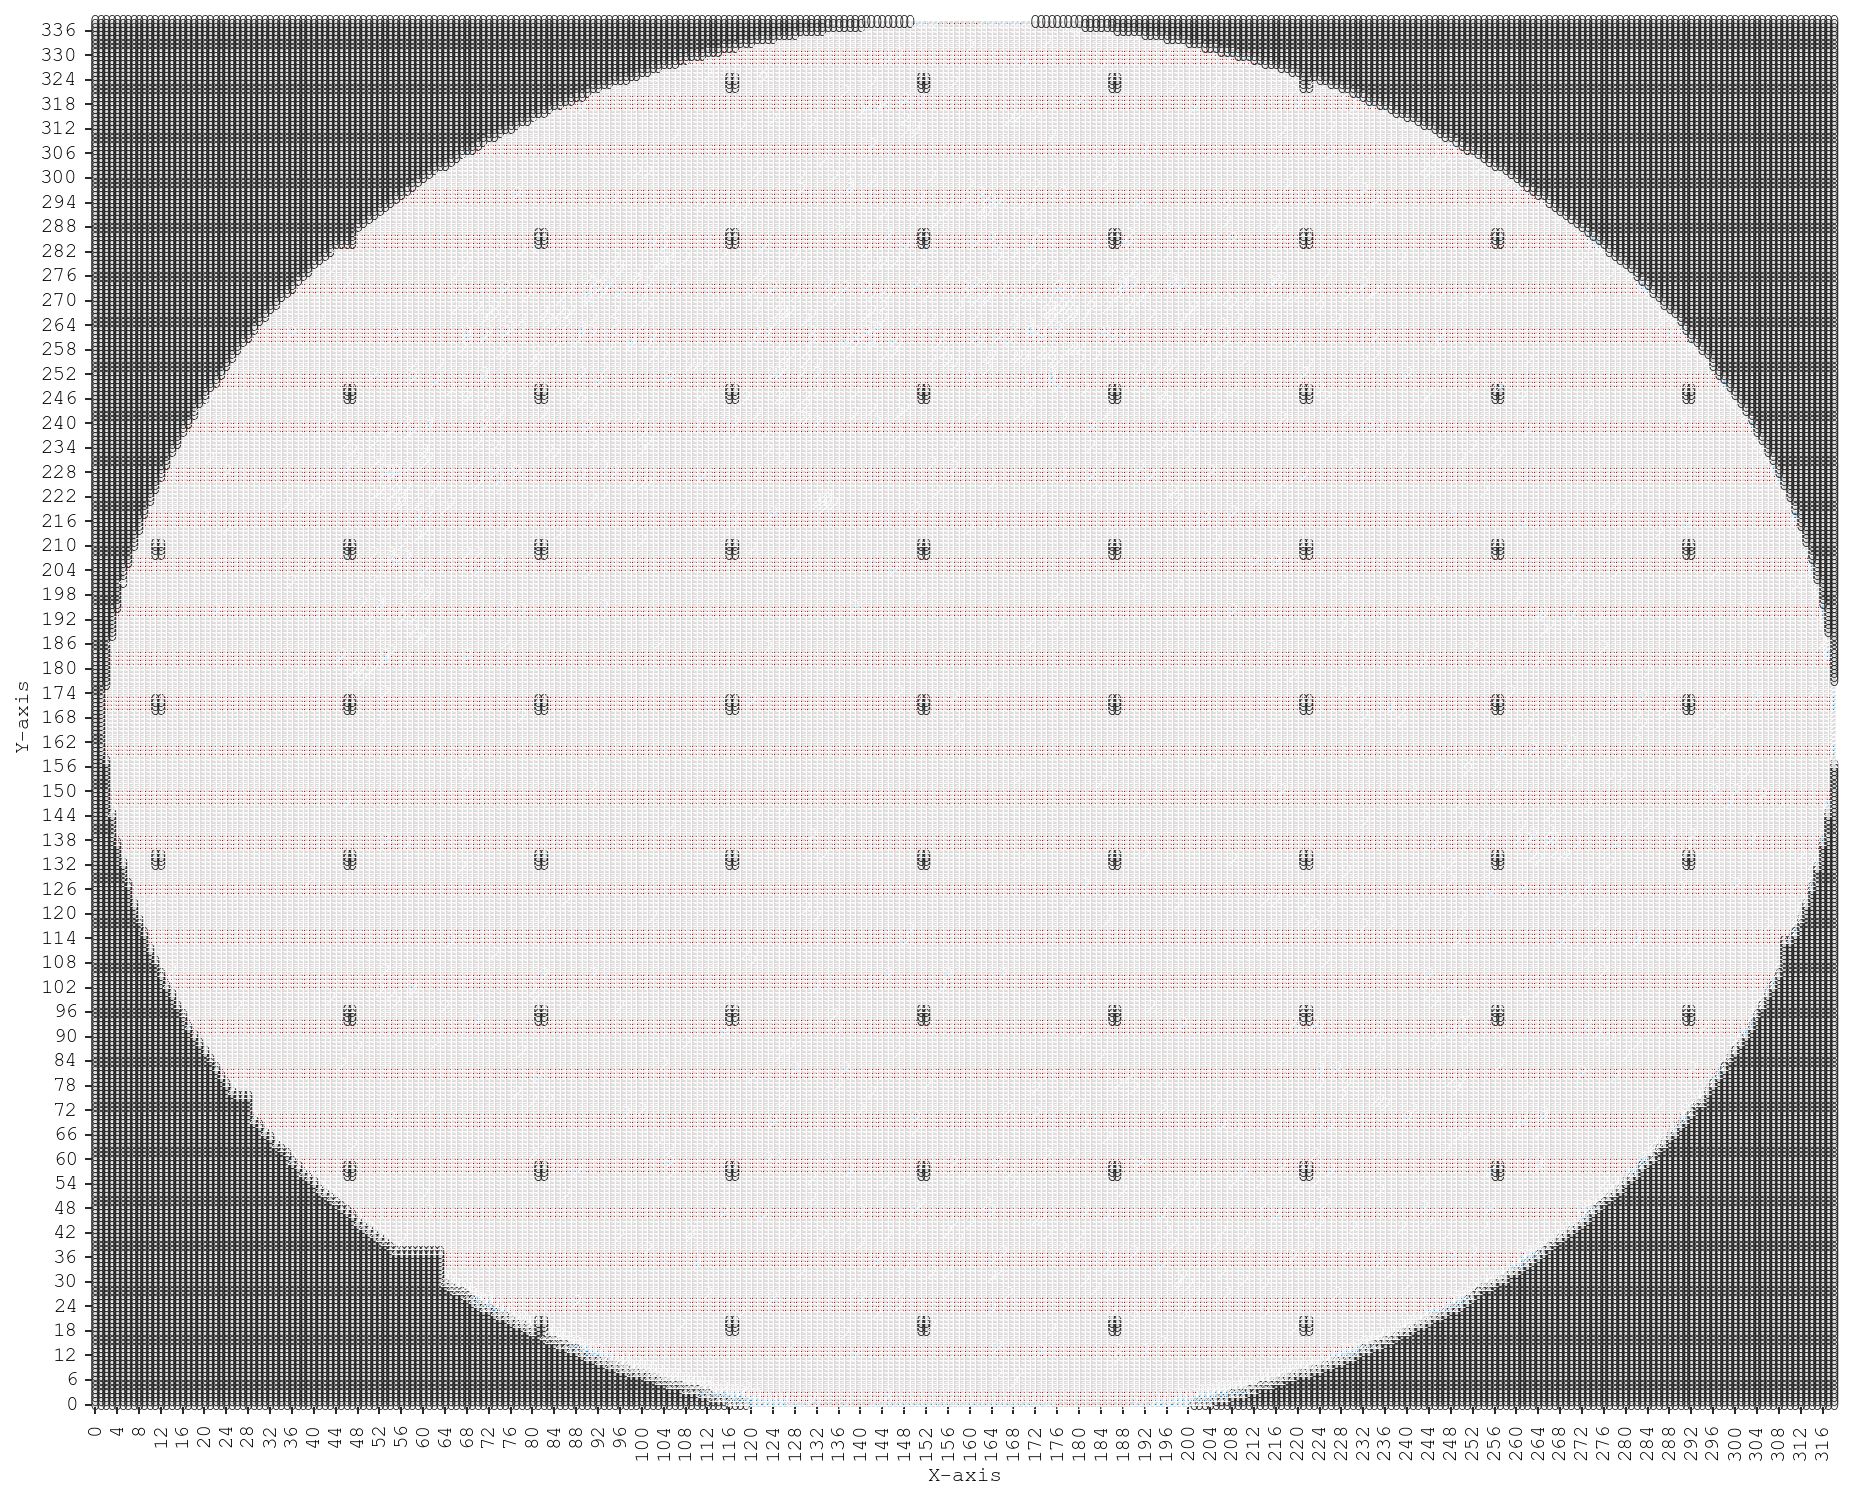

In [16]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Initialize logging with the level set to INFO
logging.basicConfig(level=logging.INFO)

def load_data(filename):
    try:
        # Read columns 1, 2, 4, 5, and 10 (J column) from the CSV, skipping the first 7 rows
        df = pd.read_csv(filename, skiprows=range(0, 7), usecols=[1, 2, 4, 5, 9])
        # Rename columns
        df.columns = ['Site', 'PF', 'X', 'Y', 'J_Column']
        # Drop rows with missing values in specified columns
        df.dropna(subset=['Site', 'PF', 'X', 'Y'], inplace=True)
        # Convert data types for specified columns
        df = df.astype({"Site": "int", "PF": "str", "X": "int", "Y": "int"})

        # Process the J_Column; set it to 'F' if it's NaN or outside the range [75.0, 105.0], else set it to 'P'
        df['J_Column'] = df['J_Column'].apply(lambda x: 'F' if pd.isna(x) or x < 75.0 or x > 105.0 else 'P')

    except FileNotFoundError:
        # Handle the case where the file is not found
        logging.error(f"File {filename} not found.")
        return None
    except pd.errors.EmptyDataError:
        # Handle the case where the file is empty
        logging.error(f"File {filename} is empty.")
        return None
    return df

def validate_and_remove_duplicates(df):
    # Identify rows with missing X or Y values
    missing_df = df[(df['X'].isna()) | (df['Y'].isna())]
    
    # Log any missing rows
    if not missing_df.empty:
        logging.info(f"Missing rows: {missing_df}")
    
    # Filter rows with positive X and Y values
    df = df[(df['X'] >= 0) & (df['Y'] >= 0)]
    
    # Identify duplicate rows based on the specified subset of columns
    to_delete_mask = df.duplicated(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    to_delete_df = df[to_delete_mask]
    
    # Log any duplicate rows
    if not to_delete_df.empty:
        logging.info(f"Duplicate rows: {to_delete_df}")
    
    # Remove duplicate rows from the main dataframe
    df = df.drop_duplicates(subset=['Site', 'PF', 'X', 'Y'], keep='last')
    
    return df, to_delete_df, missing_df

def apply_formula(df):
    # Modify the Y values based on the given formula
    df['Y'] = df['Y'] + 8 - 2 * df['Site']
    return df

def flip_x_coordinates(df):
    # Calculate the center X coordinate
    center_x = (df['X'].max() + df['X'].min()) // 2
    # Flip the X values around the center
    df['X'] = 2 * center_x - df['X']
    return df

def adjust_coordinates(df, offset=(152, 238)):
    # Adjust the X and Y coordinates based on the given offsets
    df['X'] = df['X'] - offset[0]
    df['Y'] = df['Y'] - offset[1]
    return df

def find_all_holes(grid):
    # Identify all holes (missing data regions) in the grid
    holes = []
    missing_coordinates = []
    for y in range(len(grid) - 3):
        for x in range(len(grid[0]) - 2):
            if all(grid[y + dy][x + dx] == '.' for dy in range(3) for dx in range(2)):
                if all(grid[y + dy][x + dx] in ['P', 'F'] for dy in [-1, 3] for dx in range(-1, 3)) and \
                   all(grid[y + dy][x + dx] in ['P', 'F'] for dy in range(-1, 4) for dx in [-1, 2]):
                    holes.append((x, y))
                    for dy in range(3):
                        for dx in range(2):
                            missing_coordinates.append((x+dx, y+dy))
    return holes, missing_coordinates

def visualize_data(df, holes, missing_coordinates, optional_value=None):
    # Plot the data, marking holes and missing coordinates
    plt.figure(figsize=(15, 12), dpi=150)

    # Set global font for the plot
    plt.rcParams['font.family'] = 'Courier New'  
    
    # Create a grid of zeros
    grid = [[0 for _ in range(int(df['X'].max()) + 1)] for _ in range(int(df['Y'].max()) + 1)]
    
    # Update grid with numeric values based on the dataframe values: 1 for 'P' and 2 for 'F'
    for _, row in df.iterrows():
        x, y, val = int(row['X']), int(row['Y']), row['J_Column']
        grid[y][x] = 1 if val == 'P' else 2

    # If optional_value is provided, set it to 3 on the grid
    if optional_value:
        for x, y in optional_value:
            if grid[y][x] == 0:
                grid[y][x] = 3

    # Create custom colormap
    cmap = {0: "#f5f5f5", 1: "#76b900", 2: "#db0200", 3: "#0091ff"}
    custom_cmap = [cmap[i] for i in range(4)]

    # Convert the grid to a dataframe and visualize it
    grid_df = pd.DataFrame(grid)
    sns.heatmap(grid_df, cmap=custom_cmap, annot=True, fmt="", cbar=False, linewidths=0.5, linecolor='#d9d9d9')
    plt.gca().invert_yaxis()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    
    # Highlight holes and missing coordinates
    for x, y in holes:
        plt.gca().add_patch(plt.Rectangle((x, y), 2, 3, fill=False, edgecolor='yellow', lw=2))
    for x, y in missing_coordinates:
        plt.plot(x + 0.5, y + 0.5, 'yo')
    
    plt.show()

def main(optional_value=None):
    all_data = []  # 初始化空列表用于存储所有数据
    filename = 'C:/Users/TP/Documents/CQ6248.1-01.csv'
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    all_data.append(df)
    txt_filename = f'C:/Users/TP/Documents/CQ6248.1-01_processed{"_filtered" if optional_value else ""}.txt'
    txt_filename_adjusted = f'C:/Users/TP/Documents/最初的4列{"_filtered" if optional_value else ""}.txt'  # 新文件名
    
    df = load_data(filename)
    if df is None:
        logging.error("Data loading failed.")
        return
    
    df, to_delete_df, missing_df = validate_and_remove_duplicates(df)
    df = apply_formula(df)
    df = flip_x_coordinates(df)

    # 添加偏移量调整
    offset = (152, 258)  # 你可以根据需要调整这个值
    df_adjusted = adjust_coordinates(df.copy(), offset)  # 创建一个调整后的 DataFrame 副本
    
    # 生成原始数据的 TXT 文件
    generate_txt_from_df(df, txt_filename)

    # 生成调整后数据的 TXT 文件
    generate_txt_from_df(df_adjusted, txt_filename_adjusted)
    if optional_value:
        df = df[df['Site'] == optional_value]

    logging.info("These are the duplicate rows that will be deleted:")
    logging.info(to_delete_df)

    generate_txt_from_df(df, txt_filename)

    max_x = int(df['X'].max())
    max_y = int(df['Y'].max())
    grid = [['.' for _ in range(max_x + 1)] for _ in range(max_y + 1)]

    for index, row in df.iterrows():
        grid[int(row['Y'])][int(row['X'])] = row['PF']

    holes, missing_coordinates = find_all_holes(grid)
    if holes:
        logging.info(f"Valid holes found at top-left corners: {holes}.")

    for x, y in missing_coordinates:
        if df[(df['X'] == x) & (df['Y'] == y)].empty:
            new_row = {'Site': -1, 'PF': 'M', 'X': x, 'Y': y}
            df = pd.concat([df, pd.DataFrame([new_row])]).reset_index(drop=True)

    visualize_data(df, holes, missing_coordinates, optional_value)
    
    first_hole, surrounding_coordinates, surrounding_status = find_first_hole_and_surroundings(grid)
    if first_hole:
        logging.info(f"First valid hole found at top-left corner: {first_hole}.")
        logging.info(f"Surrounding coordinates: {surrounding_coordinates}")
        logging.info(f"Surrounding statuses: {surrounding_status}")
    #total fail，pass& test formula：total test=total pass value+ total fail value   
    TOTAL_FAIL = len(to_delete_df)
    logging.info(f"TOTAL_FAIL: {TOTAL_FAIL}")

    TOTAL_PASS = len(df[df['PF'] == 'P'])
    logging.info(f"TOTAL_PASS: {TOTAL_PASS}")

    TOTAL_TEST = TOTAL_PASS + TOTAL_FAIL
    logging.info(f"TOTAL_TEST: {TOTAL_TEST}")   

if __name__ == "__main__":
    df = load_data("C:/Users/TP/Documents/CQ6248.1-01.csv")
    if df is not None:
        df, duplicates, missing_rows = validate_and_remove_duplicates(df)
        df = apply_formula(df)
        df = flip_x_coordinates(df)
        df = adjust_coordinates(df)
        holes, missing_coordinates = find_all_holes(df.to_numpy())
        visualize_data(df, holes, missing_coordinates)
